# Introducción.

La cátedra de Teoría de la Información ha proporcionado cuatro datasets con la finalidad de que se realice el análisis de las temperaturas promedio de tres ciudades con condiciones meteorológicas bastante distintas. Estas tres ciudades son introducidas por la cátedra de la siguiente manera:

- Quito: donde la temperatura no cambia ni aunque recen diez climas distintos.

- Melbourne: donde podés experimentar las cuatro estaciones antes del almuerzo.

- Oslo: donde el clima no se decide si quiere ser Siberia o un spa nórdico.

Brindando un poco de contexto geográfico, Quito es la capital de Ecuador, Melbourne es una ciudad de Australia (fue su capital entre 1901 y 1927) y Oslo es la capital y ciudad más poblada de Noruega. Para poder tener en claro la distancia entre estos países, se invita a observar el siguiente mapa, en el que se encuentran coloreados los tres países a los que pertenecen las ciudades a analizar:

<img src="images/mapa.png" width="" align="" />

Habiendo introducido la tarea asignada y un poco de contexto geográfico, se realiza el trabajo de preparar todo lo necesario para analizar los datos (la importación de las librerías, la carga de los datos y su limpieza) y resolver las consignas propuestas.

## Importación de Librerías.

Se importan las librerías necesarias que se utilizarán a lo largo del trabajo:

In [4]:
# Utilizada para la obtención de valores aleatorios.
import random

# Utilizada en la lectura de los datos.
import pandas as pd

# Utilizada en la creación de matrices.
import numpy as np

# Utilizadas en la visualización de los datos.
import matplotlib.pyplot as plt
import seaborn as sns

## Carga de los Datos.

Se realiza la lectura y carga de los datasets:

In [7]:
# Datasets correspondientes a las temperaturas de Quito, Melbourne y Oslo, mencionados en la explicación.
dataset_raw_quito=pd.read_csv("temperature_Quito_celsius.csv")
dataset_raw_melbourne=pd.read_csv("temperature_Melbourne_celsius.csv")
dataset_raw_oslo=pd.read_csv("temperature_Oslo_celsius.csv")

# (Este dataset será usado e introducido recién en la parte 4).
dataset_raw_melbourne_ruidoso = pd.read_csv("temperature_Melbourne_celsius_ruidoso.csv")

Los datasets contienen las temperaturas promedio de las ciudades, tomadas durante:

In [3]:
print("Tamaño del dataset de Quito: ", dataset_raw_quito.shape[0])
print("Tamaño del dataset de Melbourne: ", dataset_raw_melbourne.shape[0])
print("Tamaño del dataset de Oslo: ", dataset_raw_oslo.shape[0])
print("Tamaño del dataset de Melbourne ruidoso: ", dataset_raw_melbourne_ruidoso.shape[0])

Tamaño del dataset de Quito:  5844
Tamaño del dataset de Melbourne:  5844
Tamaño del dataset de Oslo:  5844
Tamaño del dataset de Melbourne ruidoso:  5844


5844 días en cada uno de los casos, lo que equivale a 16 años de 365 días o a exactamente 16 años si se considera que, cada 4 años, uno de estos es bisiesto.

## Limpieza de los Datos.

Se identificaron outliers en los datasets de Melbourne y Oslo, al igual que en el de Melbourne ruidoso (este último será introducido y utilizado recién en la parte 4). Estos pueden ser presenciados en los siguientes boxplots:

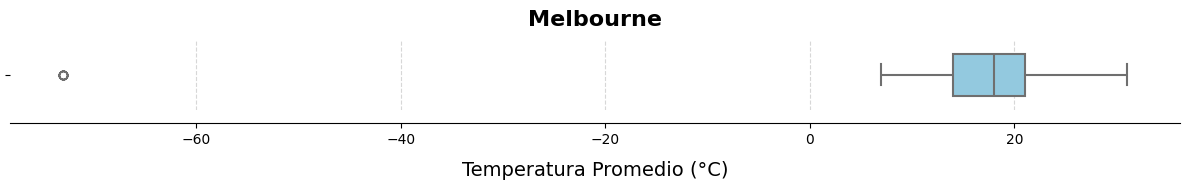

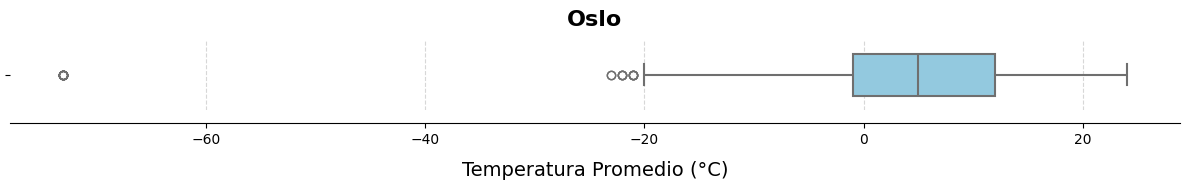

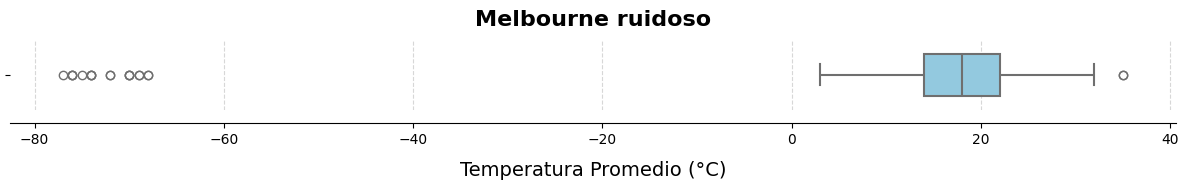

In [79]:
def mostrar_boxplot(dataset, x, title, xlabel):
    plt.figure(figsize=(12, 2))

    # Boxplot más fino, con control de outliers y líneas
    sns.boxplot(
        x=dataset[x],
        color='skyblue',
        width=0.6,
        fliersize=6,  # Tamaño de los outliers.
        linewidth=1.5
    )

    plt.title(title, fontsize=16, fontweight='bold', pad=10)
    plt.xlabel(xlabel, fontsize=14, labelpad=10)
    sns.despine(offset=10, left=True)
    plt.grid(axis='x', linestyle='--', alpha=0.5)  # Línea guía sutil en X

    plt.tight_layout()
    plt.show()

mostrar_boxplot(dataset_raw_melbourne, "AvgTemperature", "Melbourne", "Temperatura Promedio (°C)")
mostrar_boxplot(dataset_raw_oslo, "AvgTemperature", "Oslo", "Temperatura Promedio (°C)")
mostrar_boxplot(dataset_raw_melbourne_ruidoso, "AvgTemperature", "Melbourne ruidoso", "Temperatura Promedio (°C)")

En los dos primeros datasets, el valor de los outliers es el mismo: -73. Por otro lado, en el de Melbourne ruidoso, estos outliers varían entre -77.0 y -68.0.

A destacar: en el dataset de Oslo figuran otros datos inferiores al bigote inferior de la caja, sin embargo, estos son datos inusuales, pero reales. Por consiguiente, se tomó la decisión de que permanezcan en el dataset.

Al momento de manejar estos outliers, se evaluaron distintas alternativas, tales como:

- Eliminar todas las entradas del dataset en las que aparezca dicha temperatura. Sin embargo, esto implicaría, para mantener consistencia, eliminar dichos días también de los demás datasets. Y, al estar realizadas las mediciones por días, perderlas dificultaría la toma de estadísticas entre años.

- Imputar los datos, a partir de sus datos vecinos. En la mayoría de las ocasiones en las que aparece un outlier, los valores anteriores siguen un comportamiento lógico, el cual permite estimar cuál es el valor que debería haber en el lugar del outlier.

Se presenta a continuación una secuencia de datos del dataset de Melbourne en la que puede presenciarse lo anteriormente mencionado:

In [5]:
print(dataset_raw_melbourne.loc[[1450, 1451, 1452, 1453, 1454, 1455, 1456, 1457, 1458, 1459]])

      AvgTemperature
1450            20.0
1451            22.0
1452            22.0
1453           -73.0
1454           -73.0
1455            22.0
1456            22.0
1457            23.0
1458            24.0
1459           -73.0


Para imputar dichos datos, se obtienen sus correspondientes índices del dataset:

In [6]:
def get_indexes_outliers(dataset, min_range, max_range=None):

    # Si no se especifica un max_range, se usa un valor exacto.
    if max_range is None:
        return list(dataset[dataset["AvgTemperature"] == min_range].index)
    
    # Se busca por rangos.
    return list(dataset[(dataset["AvgTemperature"] >= min_range) & 
                       (dataset["AvgTemperature"] <= max_range)].index)

datos_basura_melbourne = get_indexes_outliers(dataset_raw_melbourne, -73.0)
datos_basura_oslo = get_indexes_outliers(dataset_raw_oslo, -73.0)
datos_basura_melbourne_ruidoso = get_indexes_outliers(dataset_raw_melbourne_ruidoso, -77.0, -68.0)

print("Indices de datos basura: ")
print(datos_basura_melbourne)
print(datos_basura_oslo)
print(datos_basura_melbourne_ruidoso)

Indices de datos basura: 
[1453, 1454, 1459, 1460, 1470, 2246, 2725, 2726, 2727, 2728, 2806, 2981, 3187, 4622, 4790, 5015, 5212]
[1453, 1454, 1459, 1460, 1470, 2725, 2726, 2727, 2728, 4622, 4723, 5212]
[1453, 1454, 1459, 1460, 1470, 2246, 2725, 2726, 2727, 2728, 2806, 2981, 3187, 4622, 4790, 5015, 5212]


Utilizando los anteriores índices, como se mencionó, se completa el dato a partir de los datos anteriores, realizando una imputación por media móvil de orden 5 (es decir, se remplaza el outlier por el promedio de los cinco datos anteriores):

In [7]:
def imputar_dataset(indexes, dataset, orden=5):
    # Se realiza una copia para no modificar el dataset original.
    out = dataset.copy()
    for index in indexes:
        if index >= orden:
            out["AvgTemperature"][index] = round(out["AvgTemperature"][index - orden:index].mean())
    return out

cleaned_dataset_quito = dataset_raw_quito.copy() # Se redefine el nombre para mayor claridad.
cleaned_dataset_melbourne = imputar_dataset(datos_basura_melbourne, dataset_raw_melbourne)
cleaned_dataset_oslo = imputar_dataset(datos_basura_oslo, dataset_raw_oslo)
cleaned_dataset_melbourne_ruidoso = imputar_dataset(datos_basura_melbourne_ruidoso, dataset_raw_melbourne_ruidoso)

A continuación, se grafican nuevamente los boxplots con la finalidad de mostrar que los datos fueron efectivamente imputados:

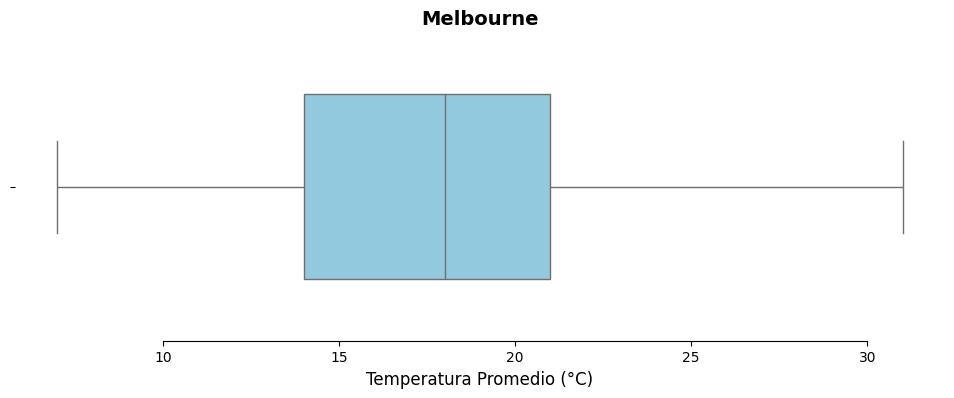

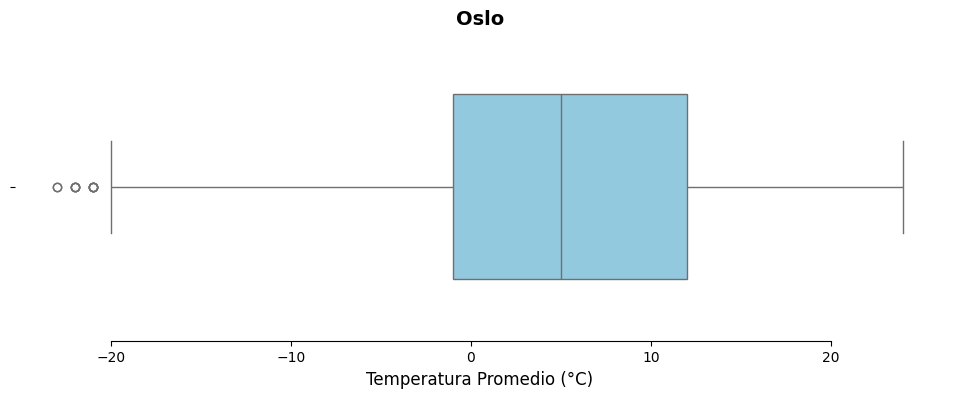

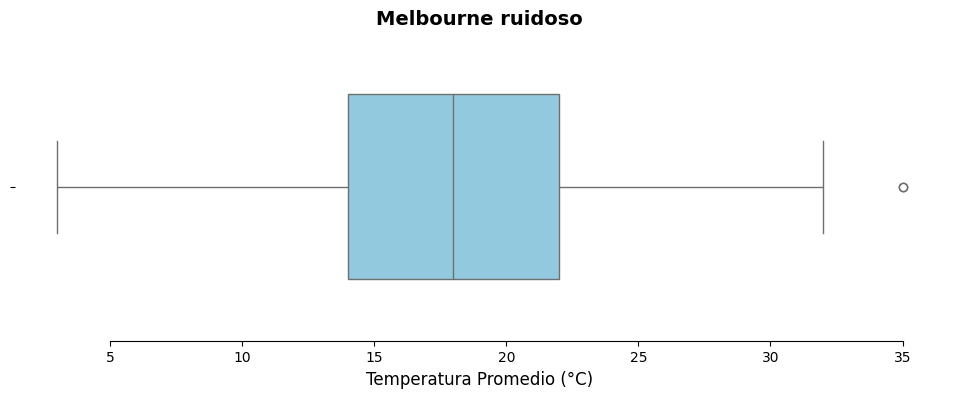

In [8]:
# Se observan nuevamente los boxplots con la finalidad de corroborar la limpieza de los datos.
mostrar_boxplot(cleaned_dataset_melbourne, "AvgTemperature", "Melbourne", "Temperatura Promedio (°C)")
mostrar_boxplot(cleaned_dataset_oslo, "AvgTemperature", "Oslo", "Temperatura Promedio (°C)")
mostrar_boxplot(cleaned_dataset_melbourne_ruidoso, "AvgTemperature", "Melbourne ruidoso", "Temperatura Promedio (°C)")

Habiendo comprobado que los datos están limpios, se comenzó con la resolución del trabajo práctico.

# Parte 1: Estadísticas para ingenieros que miran el cielo.

Dadas las señales de temperaturas diarias registradas durante cierto periodo en las tres ciudades anteriormente mencionadas, expresadas como valores enteros, en °C (grados centígrados), se pide:

## 1.1 Calcular la temperatura promedio y la desviación estándar para cada señal Si y analizar cómo se comportan estadísticamente.

Se realiza el cálculo de los promedios de las tres ciudades:

In [9]:
def calcular_promedio(dataset):
    suma = 0
    for temperature in dataset["AvgTemperature"]:
        suma = suma + temperature
    return suma / len(dataset["AvgTemperature"])

promedio_quito = calcular_promedio(cleaned_dataset_quito)
promedio_melbourne = calcular_promedio(cleaned_dataset_melbourne)
promedio_oslo = calcular_promedio(cleaned_dataset_oslo)

Y se realiza el cálculo de sus desviaciones estándar:

In [10]:
def calcular_desvio_estandar(dataset, promedio):
    suma = 0
    for temperature in dataset["AvgTemperature"]:
        suma += pow(temperature - promedio, 2)
    return np.sqrt(suma/len(dataset["AvgTemperature"]-1)) 

desvio_quito = calcular_desvio_estandar(dataset_raw_quito, promedio_quito)
desvio_melbourne = calcular_desvio_estandar(cleaned_dataset_melbourne, promedio_melbourne)
desvio_oslo = calcular_desvio_estandar(cleaned_dataset_oslo, promedio_oslo)

Los resultados obtenidos, redondeados a tres decimales, son los siguientes:

In [11]:
print("Resultados de Quito:")
print("Promedio: ", round(promedio_quito, 3))
print("Desviación estándar: ", round(desvio_quito, 3))

print("\nResultados de Melbourne:")
print("Promedio: ", round(promedio_melbourne, 3))
print("Desviación estándar: ", round(desvio_melbourne, 3))

print("\nResultados de Oslo:")
print("Promedio: ", round(promedio_oslo, 3))
print("Desviación estándar: ", round(desvio_oslo, 3))

Resultados de Quito:
Promedio:  13.604
Desviación estándar:  1.302

Resultados de Melbourne:
Promedio:  17.803
Desviación estándar:  4.252

Resultados de Oslo:
Promedio:  4.771
Desviación estándar:  8.79


De lo obtenido, se puede observar:

- En Quito, una temperatura promedio de aproximadamente 13.6 °C, con una desviación estándar de 1.3 °C. Es decir, la temperatura muy rara vez cambia y, si lo hace, siempre es un rango de aproximadamente 12.3 °C y 14.9 °C. Esto se corresponde con la descripción de la ciudad dada por la cátedra: "donde la temperatura no cambia ni aunque recen diez climas distintos".

- En Melbourne, se observa el promedio de temperatura más alto, siendo este de 17.8 °C, con una desviación estándar de 4.3 °C aproximadamente. Esto, si se compara con los datos obtenidos en Quito, indica una mayor dispersión de los datos con respecto a la temperatura promedio.

- En Oslo, se observa el promedio de temperatura más bajo entre las tres ciudades, con una media de 4.8 °C aproximadamente, y, a su vez, la desviación estándar más alta, de 8.8 °C aproximadamente, lo que indica que es la ciudad, de las analizadas, en la que más dispersas se hallan las temperaturas con respecto a su media.

## 1.2 Calcular el factor de correlación cruzada entre cada par de señales. Discutir si existen correlaciones significativas.

La correlación cruzada es una medida de la similitud entre dos fuentes, considerando un posible desfase temporal (al que se llamará lag) entre ellas. Se utiliza para identificar si hay una relación entre dos señales. El coeficiente de correlación cruzada permite cuantificar esta similitud. Varía entre -1 y +1, donde: -1 indica una correlación negativa perfecta; 0, ninguna correlación; y +1, una correlación positiva perfecta. 

Se define la función que, dados dos vectores de datos, sus promedios, sus desvíos y un lag, calcula su factor de correlación cruzada:

In [12]:
def get_factor_correlacion_cruzada(x, y, promedio_x, promedio_y, desvio_x, desvio_y, lag):
    
    # Se obtiene el número de datos.
    N = len(x)
    
    # Se aplica el desfase (lag) a y.
    # Se rotan los datos de y tanto como lo diga el desfase.
    # Si y = [A, B, C, D, E] y el desfase es 2, se obtiene [D, E, A, B, C], por ejemplo.
    y_lag = [y[(i - lag) % N] for i in range(N)]
    
    # Númerador del factor de correlación (covarianza cruzada).
    num = sum(
        (x[i] - promedio_x) * (y_lag[i] - promedio_y) 
        for i in range(N)
    ) / N
    
    # Denominador.
    denom = desvio_x * desvio_y
    
    if denom == 0:
        return 0  # Para evitar la división por cero.
    
    return num / denom

Se define, además, una función que permita calcular el factor entre dos ciudades para distintos lags y permita observar gráficamente los resultados:

In [13]:
def mostrar_grafico_de_correlacion(x, y, promedio_x, promedio_y, desvio_x, desvio_y, min_lag, max_lag, marca, titlex="X", titley="Y"):

    lags = []
    factores = []

    # Por cada lag en el rango...
    for lag in range(min_lag, max_lag):
        r = get_factor_correlacion_cruzada(x, y, promedio_x, promedio_y, desvio_x, desvio_y, lag)
        lags.append(lag)
        factores.append(r)

    plt.figure(figsize=(10, 6))
    plt.plot(lags, factores)
    plt.xlabel("Lag (días)")
    plt.ylabel("Factor de correlación cruzada")
    plt.title(f"Correlación cruzada entre {titlex} y {titley}")

    # Se colocan líneas verticales en cada posición de marca.
    posiciones_marcas = list(range(min_lag, max_lag, marca))
    for pos in posiciones_marcas:
        plt.axvline(x=pos, color='orange', linestyle='--', alpha=0.7)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

A continuación, se invoca a la función anterior, calculando el factor para cada par de ciudades, y colocando una marca cada seis meses (lo que equivale a 182 días aproximadamente):

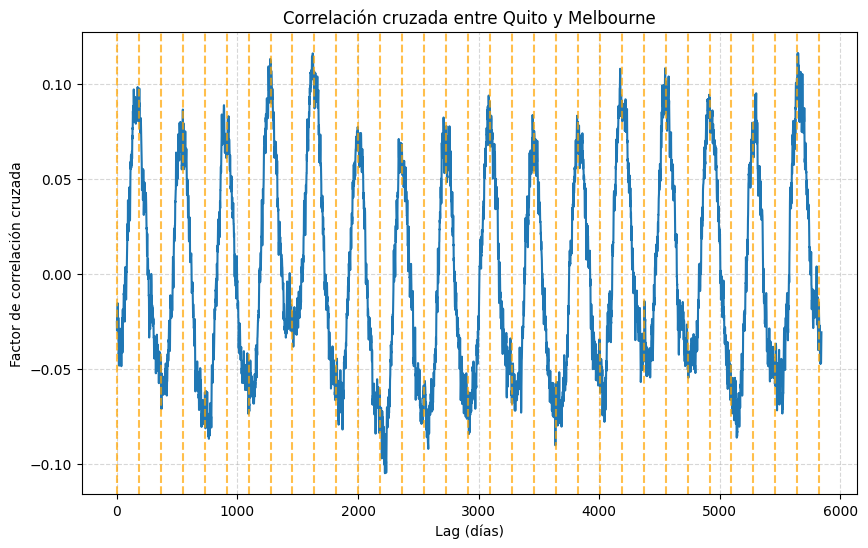

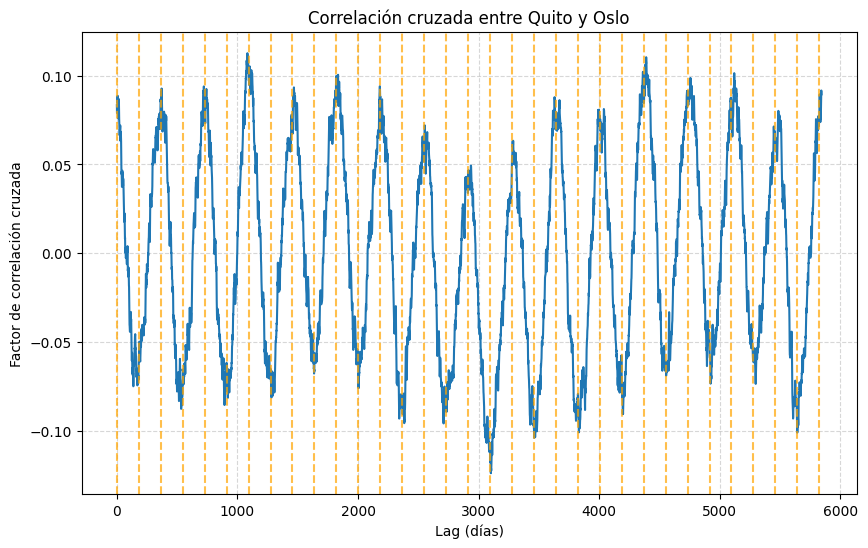

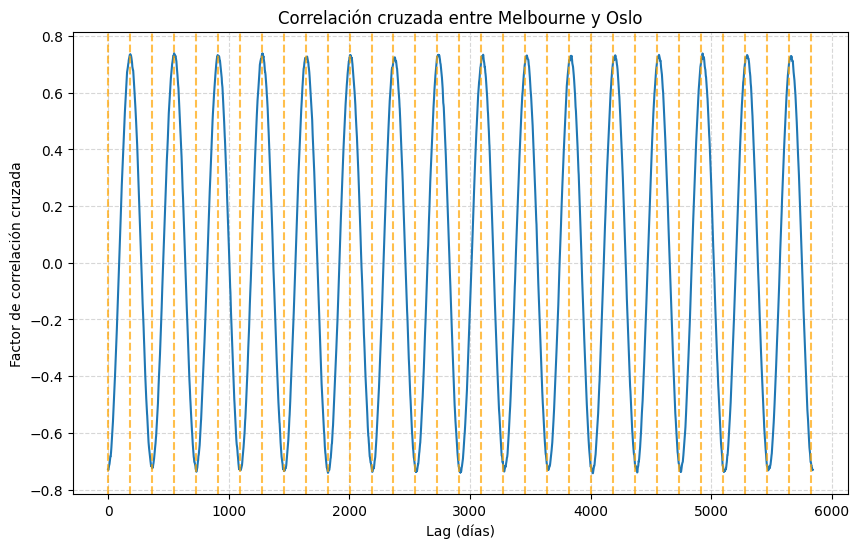

In [14]:
# Conversión de los ddatasets a arreglos.
quito_array = cleaned_dataset_quito["AvgTemperature"].values
melbourne_array = cleaned_dataset_melbourne["AvgTemperature"].values
oslo_array = cleaned_dataset_oslo["AvgTemperature"].values

desfase = 5843 # En días.
marca = 182 # En días.

mostrar_grafico_de_correlacion(quito_array, melbourne_array, promedio_quito, promedio_melbourne, desvio_quito, desvio_melbourne, 0, desfase, marca, "Quito", "Melbourne")
mostrar_grafico_de_correlacion(quito_array, oslo_array, promedio_quito, promedio_oslo, desvio_quito, desvio_oslo, 0, desfase, marca, "Quito", "Oslo")
mostrar_grafico_de_correlacion(melbourne_array, oslo_array, promedio_melbourne, promedio_oslo, desvio_melbourne, desvio_oslo, 0, desfase, marca, "Melbourne", "Oslo")

Gráficamente, a medida que se incrementa el lag, los resultados forman una senoidal. En el caso de los pares que incluyen a Quito, el factor de correlación obtenido con suerte supera el valor absoluto 0.1, lo que indica que pareciera no haber un acople entre Quito y las demás ciudades. Sin embargo, el resultado entre Melbourne y Oslo es diferente: además de observarse una senoidal más definida, también es posible observar que se alcanza el valor absoluto de 0.7, lo que indica un acople relativamente significativo entre estas ciudades.

Las marcas anaranjadas en los gráficos no fueron colocadas al azar: se observó que los picos o valles con el valor absoluto mencionado ocurren cada seis meses, coincidentes con el cambio de estación. Y esto, por supuesto, no es casualidad: en Melbourne, es verano de diciembre a febrero, mientras que en Oslo, es invierno durante esos mismos meses; y viceversa: cuando es invierno en Melbourne (junio a agosto), es verano en Oslo. Entonces, al realizar un desfase de seis meses, lo que se está realizando es comparar el verano de Melbourne con el verano de Oslo, y así sucesivamente. Cuando el desfase es múltiplo de un año, se obtiene un valle, el mínimo factor, puesto a que se están comparando estaciones opuestas: invierno y verano. Al ser las temperaturas en verano y en invierno similares en ambas ciudades, es lógico entonces que el factor de correlación dé relativamente alto.

Analizando lo obtenido, no es posible realizar ninguna afirmación acerca de que el "el clima de una ciudad prediga el de la otra", como sugiere la consigna. El comportamiento observado es normal y esperado dada la naturaleza de las estaciones y el hecho de que las ciudades tengan temperaturas promedio parecidas.

# Parte 2: Una fuente de calor markoviana.

En esta segunda parte del trabajo se pide que, considerando los valores de temperatura t que componen cada señal Si, se construya una nueva señal Ti compuesta por una secuencia de símbolos discretos F, T o C, definidos según: 

- F (frío): si t < 11°C

- T (templado): si 11 ≤ t < 19°C

- C (cálido): si t ≥ 19°C

Para cumplir con lo solicitado, se consigue una versión discretizada de cada una de las fuentes, aplicando el mapeo indicando:

In [15]:
def obtener_fuente_discreta(dataset):
    # Se realiza un remplazo de los valores de temperatura por los correspondientes simbolos.
    return dataset.map(lambda x: 'F' if x < 11.0 else 'T' if x < 19.0 else 'C')

# Datasets discretizados de cada ciudad.
discrete_quito_dataset = obtener_fuente_discreta(cleaned_dataset_quito)
discrete_melbourne_dataset = obtener_fuente_discreta(cleaned_dataset_melbourne)
discrete_oslo_dataset = obtener_fuente_discreta(cleaned_dataset_oslo)

A su vez, se definen dos variables que se utilizarán, a partir de ahora, en el resto del trabajo:

In [16]:
# Se define dos constantes:
# - el número de símbolos en las fuentes;
NRO_SIMBOLOS = 3
# - y un diccionario que permita obtener el índice correspondiente a
#   cada simbolo y el símbolo de cada índice.
#   Este es especialmente útil al momento de trabajar con estructuras.
INDEX = {
    'F': 0, 0 : 'F',
    'T': 1, 1 : 'T',
    'C': 2, 2 : 'C'
}

Con las fuentes discretizadas y las variables definidas, se nos propuso, para cada Ti:

## 2.1. Modelar la fuente con memoria de orden 1 (Markov), obtener la matriz de transición y analizar su comportamiento.

Se define la función que permita el cálculo de la matriz de transición:

In [17]:
def get_matriz_transicion(secuencia):

    # Se crea una matriz de ceros.
    matriz_transicion = np.zeros((NRO_SIMBOLOS, NRO_SIMBOLOS), dtype=np.float64)

    # Se calcula la matriz de transición.
    simbolo = secuencia[0]
    for siguiente_simbolo in secuencia[1:]:
        # Se suma 1 a las apariciones de "siguiente_simbolo", dado que anteriormente salió "simbolo".
        matriz_transicion[INDEX[siguiente_simbolo], INDEX[simbolo]] += 1
        simbolo = siguiente_simbolo

    # Se divide cada celda de la matriz de transición por la cantidad de símbolos emitidos.
    suma_columnas = matriz_transicion.sum(axis=0)
    for j in range(NRO_SIMBOLOS):
        # La suma de las columnas debe dar uno.
        # Se normaliza por columna.
        if suma_columnas[j] > 0:
            # Se divide toda la columna por la cantidad de apariciones de un símbolo luego del de la columna.
            matriz_transicion[:, j] = matriz_transicion[:, j] / suma_columnas[j]

    return matriz_transicion

y una función que permita mostrar las matrices de forma prolija:

In [18]:
def mostrar_matriz(matriz, title, simbolo=" ", simbolos=None):
    if simbolos is None:
        simbolos = ["F", "T", "C"]
    
    print(f"\n{title}\n")
    
    # Encabezado alineado.
    header = f" {simbolo}  " + "".join(f"{s:>8}" for s in simbolos)
    print(header)

    # Filas con alineación.
    for i, simbolo in enumerate(simbolos):
        fila = "".join(f"{matriz[i, j]:8.3f}" for j in range(matriz.shape[1]))
        print(f"{simbolo:<3} {fila}")

Haciendo uso de la funciones anteriormente definidas, se calculan las matrices de transición para cada ciudad:

In [19]:
matriz_transicion_quito = get_matriz_transicion(discrete_quito_dataset["AvgTemperature"])
matriz_transicion_melbourne = get_matriz_transicion(discrete_melbourne_dataset["AvgTemperature"])
matriz_transicion_oslo = get_matriz_transicion(discrete_oslo_dataset["AvgTemperature"])

Y se presentan los resultados obtenidos:

In [20]:
mostrar_matriz(matriz_transicion_quito.round(3), "Matriz de Transición de Quito.", simbolo="↙")
mostrar_matriz(matriz_transicion_melbourne.round(3), "Matriz de Transición de Melbourne.", simbolo="↙")
mostrar_matriz(matriz_transicion_oslo.round(3), "Matriz de Transición de Oslo.", simbolo="↙")


Matriz de Transición de Quito.

 ↙         F       T       C
F      0.054   0.006   0.000
T      0.946   0.993   1.000
C      0.000   0.001   0.000

Matriz de Transición de Melbourne.

 ↙         F       T       C
F      0.486   0.032   0.000
T      0.514   0.837   0.145
C      0.000   0.132   0.855

Matriz de Transición de Oslo.

 ↙         F       T       C
F      0.959   0.099   0.000
T      0.041   0.866   0.296
C      0.000   0.035   0.704


De estos, es posible observar que:

- En Quito, independientemente de la temperatura anterior, lo más probable que es que la temperatura del siguiente día sea templada. Si el día anterior fue cálido, esto es un hecho. Si el día anterior fue templado o frío, es extremadamente probable que el siguiente día sea templado, aunque existe un margen de posibilidad pequeño a obtener otra temperatura. El mayor margen lo tiene asociado el frío, con una posibilidad del 5.4 % de que en el siguiente día se repita ese mismo clima.

- En Melbourne, dado que un día hizo frío, lo más probable es que al otro día esté templado. Si un día estuvo templado, lo mas probable que al siguiente también lo esté. Que esté cálido luego de un día templado es un 10 % más probable a que haga frío. Finalmente, si estuvo cálido, lo más probable es que este tiempo se repita al siguiente día.

- En Oslo, si un día hizo frío con casi total seguridad que al día siguiente también hará frío. Pasar a un día templado ocurre con un 4.1 % de probabilidad. Si el día anterior estuvo templado, entonces lo más probable es que este tiempo se repita al día siguiente. Comparte con el tiempo cálido este mismo comportamiento de repetición.

En todos los casos, dado que un día estuvo cálido, nunca va a hacer frío al día siguiente, y viceversa. Es decir, entre un día cálido y un día frío, siempre hay, al menos, un día templado de por medio.

## 2.2. Usar muestreo Monte Carlo para obtener, para cada símbolo:

### 2.2.1. La probabilidad estacionaria.

La probabilidad estacionaria o vector estacionario indica, una vez que la fuente se ha estabilizado o se halla en estado estacionario, la probabilidad de observar cada símbolo.

Para obtener el vector estacionario a partir de muestreo Monte Carlo, se realiza previamente el cálculo de la matriz estacionaria acumulada de cada ciudad:

In [21]:
def get_matriz_acumulada(matriz_transicion):

    # Se realiza una copia de la matriz de transición, para no modificar la original.
    out = matriz_transicion.copy()

    for i in range(NRO_SIMBOLOS-1): # -1, ya que se empieza a sumar desde la segunda columna.
        for j in range(NRO_SIMBOLOS):
            # Se le suma a cada fila los valores de las filas anteriores.
            out[i+1][j] += out[i][j]

    return out

# Obtención de las matrices acumuladas para cada ciudad.
matriz_acumulada_quito = get_matriz_acumulada(matriz_transicion_quito)
matriz_acumulada_melbourne = get_matriz_acumulada(matriz_transicion_melbourne)
matriz_acumulada_oslo = get_matriz_acumulada(matriz_transicion_oslo)

se definen la función de convergencia y una función que permite obtener el siguiente símbolo, dado uno anterior:

In [22]:
def get_siguiente(simbolo_anterior, nro_simbolos, matriz_transicion_acumulada):
    
    # Si no hay símbolo anterior, se retorna un símbolo aleatorio.
    if simbolo_anterior is None:
        return random.randint(0, nro_simbolos - 1)

    p = random.random()

    for i in range(nro_simbolos):
        if (p < matriz_transicion_acumulada[i, simbolo_anterior]):
            return i

    return None

In [23]:
def converge(valores_actuales, valores_anteriores, epsilon, nro_simbolos=NRO_SIMBOLOS):

    for i in range(nro_simbolos):
        if (abs(valores_actuales[i] - valores_actuales[i]) > epsilon):
            return False

    return True

Adicionalmente, se define una función que, dados los datos de ciudades, permita mostrar los gráficos de convergencia lado a lado:

In [24]:
def mostrar_graficos_de_convergencia(datos_ciudades, umbral, title="Resultado", xlabel="Iteraciones", ylabel="Probabilidad", nro_simbolos=NRO_SIMBOLOS):
    
    fig, axes = plt.subplots(1, nro_simbolos, figsize=(6 * nro_simbolos, 5))
    
    # Se grafica cada ciudad.
    for i, (nombre_ciudad, historial, iteraciones) in enumerate(datos_ciudades):
        ax = axes[i]
        
        # Se grafica cada símbolo.
        for j in range(nro_simbolos):
            ax.plot(iteraciones, historial[j], label=f'{INDEX[j]}')
        
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(f'{nombre_ciudad}')
        ax.legend()
        ax.grid(True)
    
    fig.suptitle(f'Convergencia de: {title} - Umbral: {umbral}', 
                 fontsize=16, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88) # Necesario para que el título no se superponga.
    plt.show()

y otra función que permita mostrar el vector estacionario:

In [25]:
def mostrar_resultados_por_ciudad(datos_ciudad, resultados, title="Resultados", nro_simbolos=NRO_SIMBOLOS):

    print(title)
    print("-" * 50)
    nombres_ciudades = [datos[0] for datos in datos_ciudades]
    
    # Encabezado
    header = "Ciudad".ljust(12)
    for j in range(nro_simbolos):
        header += f"{INDEX[j]}".ljust(10)
    print(header)
    print("-" * 50)
    
    # Datos
    for ciudad, vector in zip(nombres_ciudades, resultados):
        fila = f"{ciudad:<12}"
        for valor in vector:
            fila += f"{valor:.3f}".ljust(10)
        print(fila)

Por último, se define la función que permitirá la toma de muestras cada cierto número de iteraciones y el cálculo del vector estacionario:

In [26]:
def get_vector_estacionario(matriz_transicion_acumulada, nro_simbolos=NRO_SIMBOLOS, epsilon=0.000005, min_iteraciones=10000):

    apariciones = np.zeros(nro_simbolos)
    vector_estacionario = np.zeros(nro_simbolos, dtype=np.float64)
    vector_estacionario_anterior = np.full(nro_simbolos, -1, dtype=np.float64)

    simbolo = None
    iteraciones = 0

    # Se guarda el historial para graficar.
    historial_iteraciones = []
    historial = [[] for _ in range(nro_simbolos)]

    while ((iteraciones < min_iteraciones) or not converge(vector_estacionario, vector_estacionario_anterior, epsilon)):

        simbolo = get_siguiente(simbolo, nro_simbolos, matriz_transicion_acumulada)
        iteraciones += 1

        apariciones[simbolo] += 1
        vector_estacionario_anterior = vector_estacionario.copy()
        vector_estacionario = np.array([ aparicion / iteraciones for aparicion in apariciones ])

        # Cada 100 iteraciones, se añade a cada símbolo la probabilidad hallada.
        # Esto con fines de poder realizar el diagrama de convergencia.
        if iteraciones % 100 == 0:
            for i in range(nro_simbolos):
                historial[i].append(vector_estacionario[i])
            historial_iteraciones.append(iteraciones)

    return vector_estacionario, historial, historial_iteraciones

Con las funciones definidas, se realizó el cálculo para los siguientes umbrales de convergencia:

In [27]:
umbrales = [0.005, 0.0005, 0.00005, 0.0000005]

A continuación se presentan los resultados obtenidos:

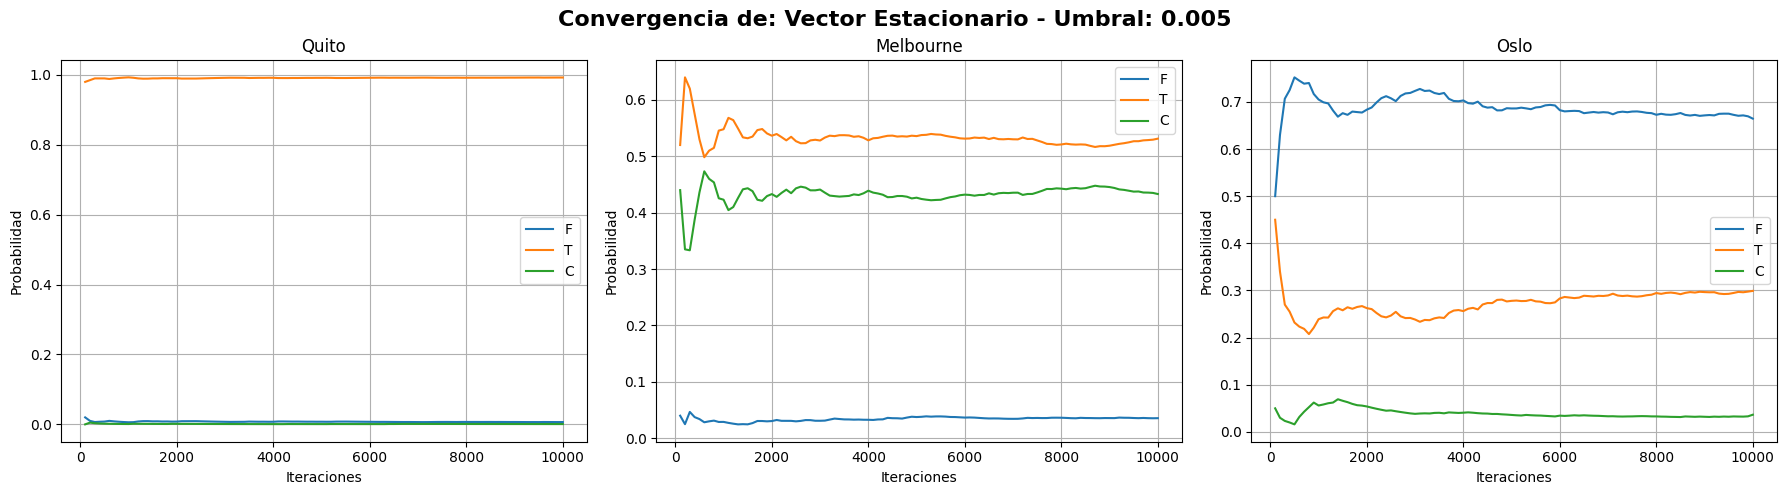

Vectores Estacionarios
--------------------------------------------------
Ciudad      F         T         C         
--------------------------------------------------
Quito       0.007     0.993     0.001     
Melbourne   0.036     0.531     0.433     
Oslo        0.664     0.299     0.036     


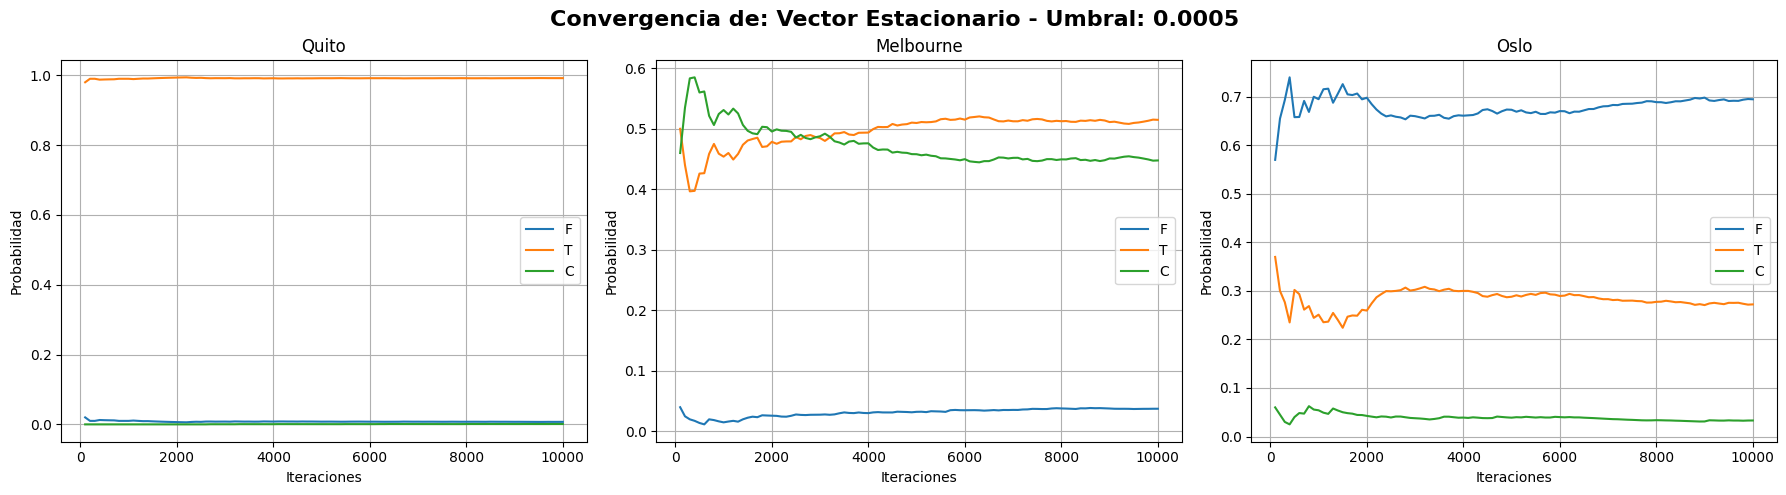

Vectores Estacionarios
--------------------------------------------------
Ciudad      F         T         C         
--------------------------------------------------
Quito       0.007     0.992     0.001     
Melbourne   0.037     0.515     0.448     
Oslo        0.695     0.272     0.033     


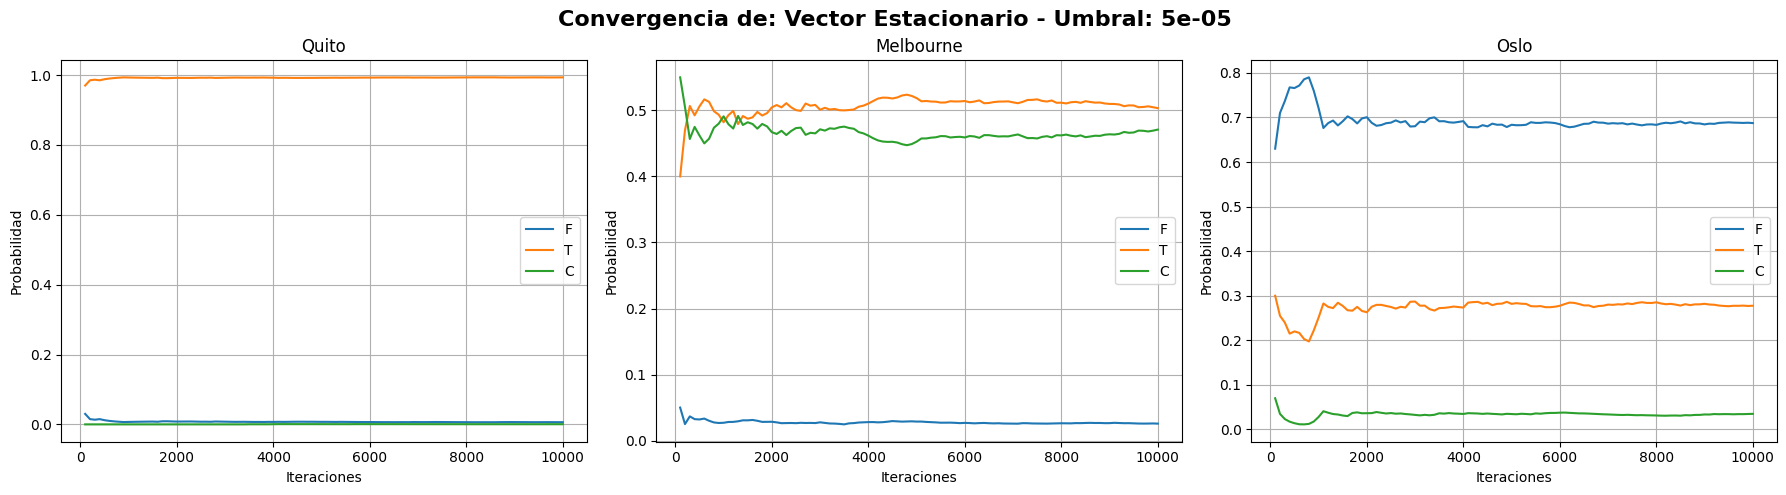

Vectores Estacionarios
--------------------------------------------------
Ciudad      F         T         C         
--------------------------------------------------
Quito       0.006     0.993     0.001     
Melbourne   0.026     0.503     0.471     
Oslo        0.687     0.278     0.035     


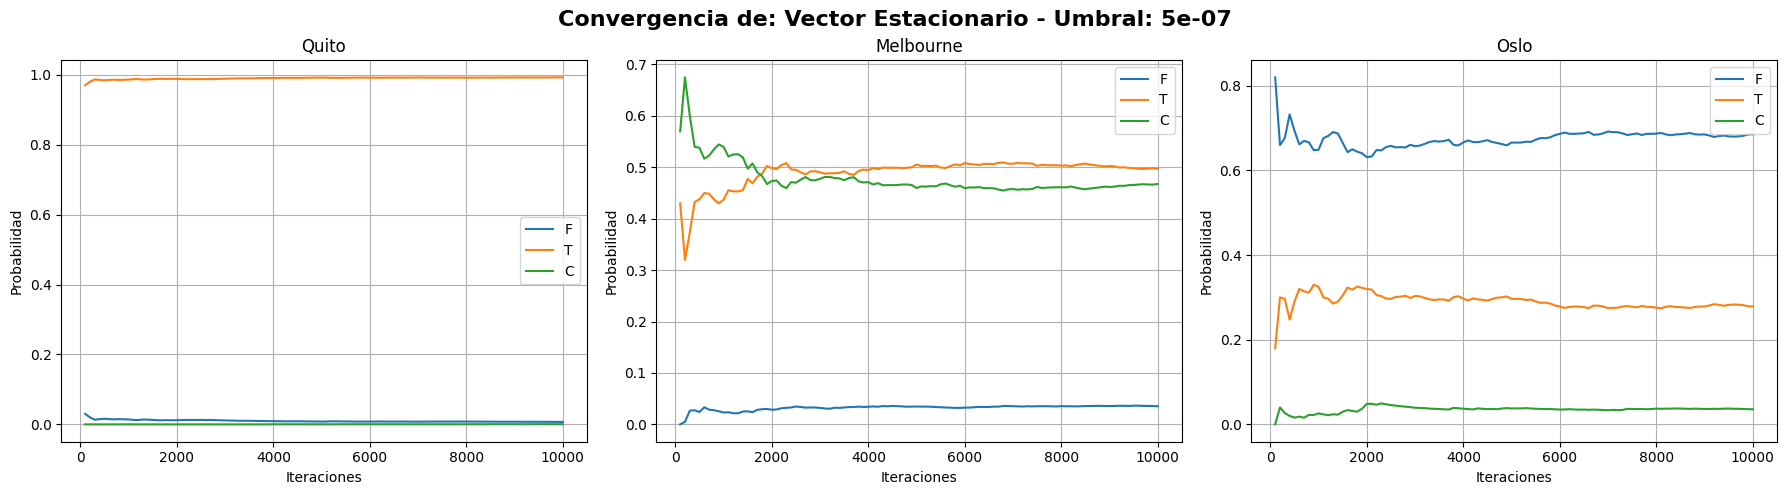

Vectores Estacionarios
--------------------------------------------------
Ciudad      F         T         C         
--------------------------------------------------
Quito       0.007     0.993     0.001     
Melbourne   0.035     0.497     0.468     
Oslo        0.686     0.279     0.036     


In [28]:
for umbral in umbrales:

    vector_estacionario_quito, historial_quito, iteraciones_quito = get_vector_estacionario(matriz_acumulada_quito, epsilon=umbral)
    vector_estacionario_melbourne, historial_melbourne, iteraciones_melbourne = get_vector_estacionario(matriz_acumulada_melbourne, epsilon=umbral)
    vector_estacionario_oslo, historial_oslo, iteraciones_oslo = get_vector_estacionario(matriz_acumulada_oslo, epsilon=umbral)

    # Se preparan los datos a mostrar.
    datos_ciudades = [
        ('Quito', historial_quito, iteraciones_quito),
        ('Melbourne', historial_melbourne, iteraciones_melbourne),
        ('Oslo', historial_oslo, iteraciones_oslo)
    ]
    mostrar_graficos_de_convergencia(datos_ciudades, umbral, title="Vector Estacionario")
    
    vectores = [vector_estacionario_quito, vector_estacionario_melbourne, vector_estacionario_oslo]
    mostrar_resultados_por_ciudad(datos_ciudades, vectores, title="Vectores Estacionarios")

Los vectores de convergencia varían mínimamente entre umbrales, siendo el de Oslo el que mayor variación presenta. Con respecto a la convergencia de estos, estos convergen antes del número mínimo de iteraciones establecido, lo que puede notarse observando el eje x en los gráficos, el cual se limita hasta la iteración establecida como mínima, y en cómo la probabilidad de cada uno de los símbolos se acerca a una línea constante.

Los resultados más "precisos" corresponden a los del umbral más bajo:

In [29]:
mostrar_resultados_por_ciudad(datos_ciudades, vectores, title="Vectores Estacionarios")

Vectores Estacionarios
--------------------------------------------------
Ciudad      F         T         C         
--------------------------------------------------
Quito       0.007     0.993     0.001     
Melbourne   0.035     0.497     0.468     
Oslo        0.686     0.279     0.036     


De estos, es posible analizar que:

- En Quito, es extremadamente raro presenciar un día que no sea templado. La temperatura casi siempre es templada.

- En Melbourne, le temperatura varía generalmente entre templada y cálida, predominando levemente las temperaturas templadas. Es muy raro hallar un día frío, aunque es más común que en Quito.

- En Oslo, la mayoría de los días son fríos, hay de vez en cuando días templados y muy rara vez se tiene un día cálido.

### 2.2.2. El tiempo medio de 1° recurrencia.

El tiempo medio de primera recurrencia indica, en promedio, cuánto tiempo pasa desde que se emite un símbolo hasta que vuelve a emitirse. En el contexto del problema, indica la cantidad de días que en, promedio, deben pasar para obtener un clima de características similares.

Para calcularlo, se define una función que, a partir de la matriz acumulada, realice su cálculo y, al igual que en la función del vector estacionario, el guardado del historial para los gráficos de convergencia:

In [30]:
def get_medias_primera_recurrencia(matriz_transicion_acumulada, nro_simbolos=NRO_SIMBOLOS, epsilon=0.0005, min_iteraciones=1000000):
    
    pasos = np.zeros(nro_simbolos)
    ocurrencias = np.zeros(nro_simbolos)
    medias_recurrencia = np.zeros(nro_simbolos, dtype=np.float64)
    t_ultima_ocurrencia = np.full(nro_simbolos, -1)
    medias_recurrencia_anterior = np.full(nro_simbolos, -1, dtype=np.float64)
    
    t_actual = 0

    simbolo = None

    # Se guarda el historial para graficar.
    historial_iteraciones = []
    historial = [[] for _ in range(nro_simbolos)]
	
    while ((t_actual < min_iteraciones) or not converge(medias_recurrencia, medias_recurrencia_anterior, epsilon)):

        simbolo = get_siguiente(simbolo, nro_simbolos, matriz_transicion_acumulada)

        # Si la señal ya apareció al menos una vez...
        if (t_ultima_ocurrencia[simbolo] >= 0):
            # Se suma la cantidad de pasos desde la última ocurrencia.
            pasos[simbolo] += t_actual - t_ultima_ocurrencia[simbolo]
            ocurrencias[simbolo] += 1

        t_ultima_ocurrencia[simbolo] = t_actual
        t_actual += 1

        # Se actualiza la media de primera recurrencia del símbolo.
        medias_recurrencia_anterior[simbolo] = medias_recurrencia[simbolo]
        if (ocurrencias[simbolo] > 0):
            medias_recurrencia[simbolo] = pasos[simbolo] / ocurrencias[simbolo]

        # Cada 100 iteraciones, se añade a cada símbolo la probabilidad hallada.
        # Esto con fines de poder realizar el diagrama de convergencia.
        if t_actual % 100 == 0:
            for i in range(nro_simbolos):
                historial[i].append(medias_recurrencia[i])
            historial_iteraciones.append(t_actual)
        
    return medias_recurrencia, historial, historial_iteraciones

Con la función definida, se realiza el cálculo de las medias de primera recurrencia para los distintos umbrales definidos anteriormente:

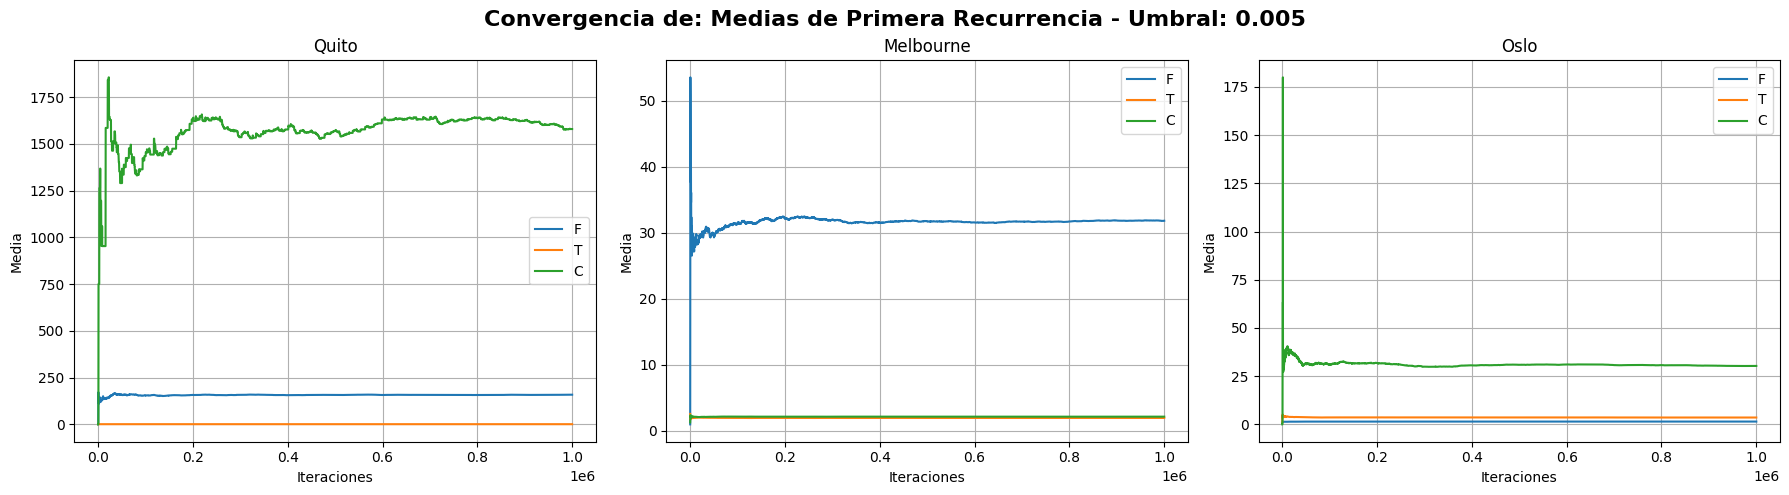

Medías de Primera Recurrencia.
--------------------------------------------------
Ciudad      F         T         C         
--------------------------------------------------
Quito       158.650   1.007     1579.948  
Melbourne   31.838    1.972     2.167     
Oslo        1.458     3.555     30.311    


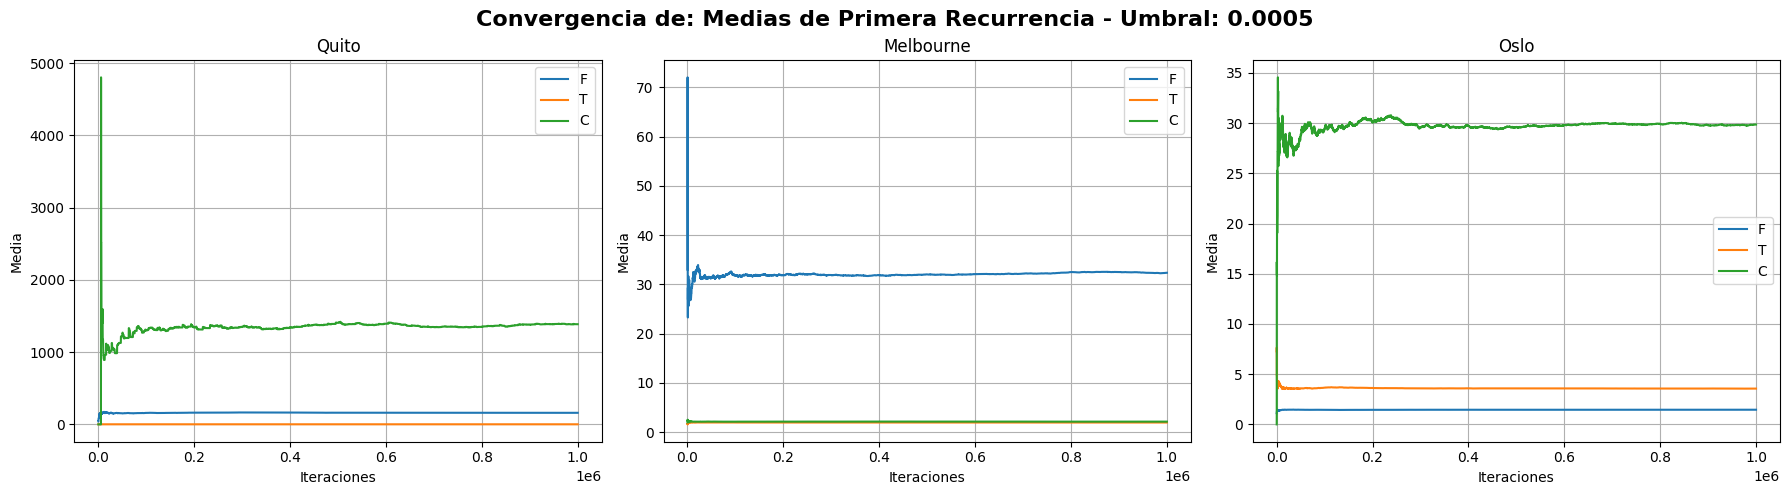

Medías de Primera Recurrencia.
--------------------------------------------------
Ciudad      F         T         C         
--------------------------------------------------
Quito       160.026   1.007     1386.578  
Melbourne   32.359    1.976     2.159     
Oslo        1.458     3.563     29.857    


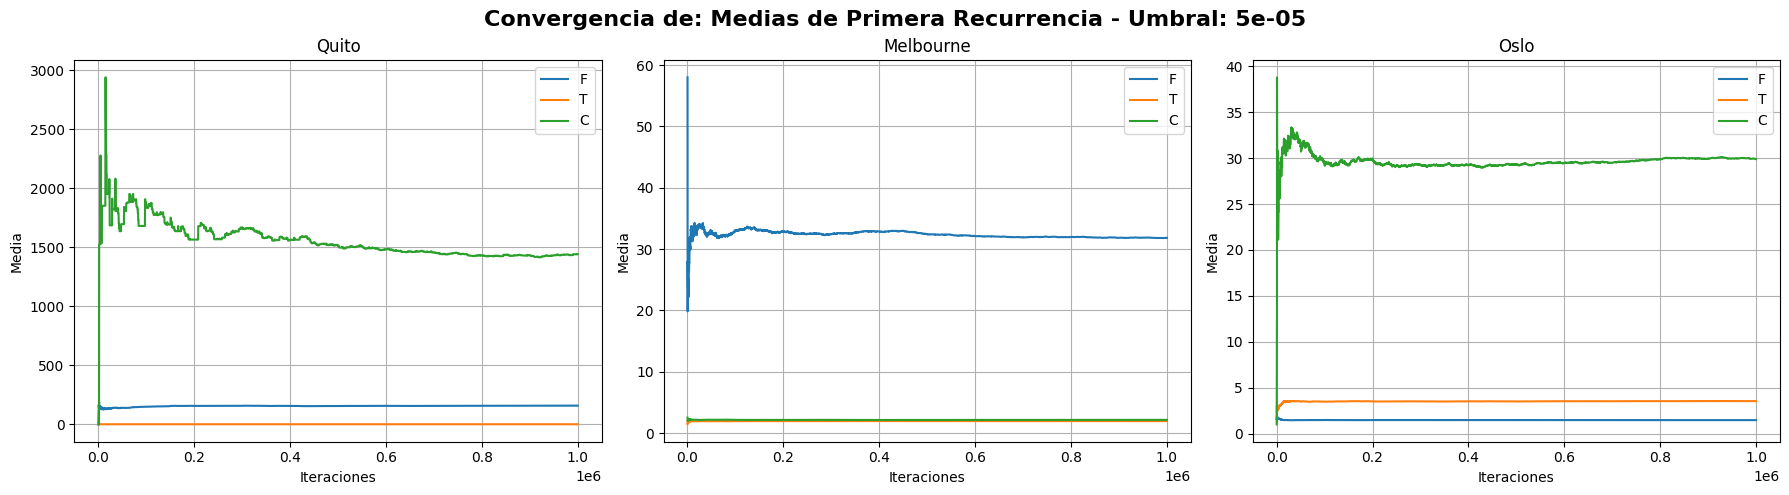

Medías de Primera Recurrencia.
--------------------------------------------------
Ciudad      F         T         C         
--------------------------------------------------
Quito       158.604   1.007     1442.374  
Melbourne   31.832    1.969     2.171     
Oslo        1.464     3.530     29.894    


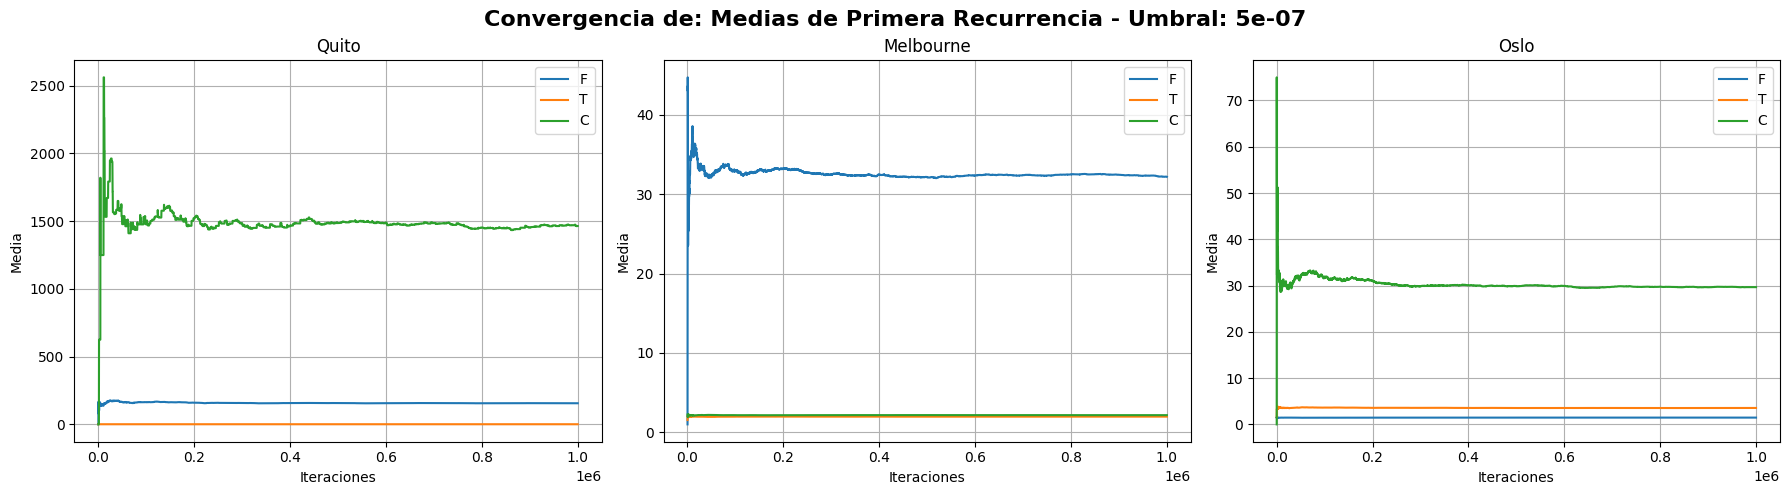

Medías de Primera Recurrencia.
--------------------------------------------------
Ciudad      F         T         C         
--------------------------------------------------
Quito       155.855   1.007     1463.883  
Melbourne   32.201    1.976     2.161     
Oslo        1.461     3.548     29.660    


In [31]:
for umbral in umbrales:

    medias_primera_recurrencia_quito, historial_quito, iteraciones_quito = get_medias_primera_recurrencia(matriz_acumulada_quito, epsilon=umbral)
    medias_primera_recurrencia_melbourne, historial_melbourne, iteraciones_melbourne = get_medias_primera_recurrencia(matriz_acumulada_melbourne, epsilon=umbral)
    medias_primera_recurrencia_oslo, historial_oslo, iteraciones_oslo = get_medias_primera_recurrencia(matriz_acumulada_oslo, epsilon=umbral)

    # Se preparan los datos a mostrar.
    datos_ciudades = [
        ('Quito', historial_quito, iteraciones_quito),
        ('Melbourne', historial_melbourne, iteraciones_melbourne),
        ('Oslo', historial_oslo, iteraciones_oslo)
    ]
    mostrar_graficos_de_convergencia(datos_ciudades, umbral, title="Medias de Primera Recurrencia", ylabel="Media")
    
    medias_primera_recurrencia = [medias_primera_recurrencia_quito, medias_primera_recurrencia_melbourne, medias_primera_recurrencia_oslo]
    mostrar_resultados_por_ciudad(datos_ciudades, medias_primera_recurrencia, title="Medías de Primera Recurrencia.")

En contraste con los gráficos de convergencia de los vectores estacionarios, es posible observar, especialmente para el símbolo C en Quito, mayor oscilación hasta alcanzar la convergencia y mayor variación entre los resultados para los distintos umbrales. Es debido a estas razones que se definió un mínimo de iteraciones más alto para este cálculo que el definido para el del vector estacionario.

En general, los resultados obtenidos para los distintos umbrales son similares, siendo el símbolo C de Quito el que mayor variación presenta.

Tanto en el cálculo de los vectores estacionarios como en el cálculo de las medias de primera recurrencia, la similitud entre los valores obtenidos para los distintos umbrales indica que no es necesario el uso de un umbral muy chico para obtener resultados precisos.

# Parte 3: Entropía, Huffman y la batalla por los bits

## 3.1. Calcular la entropía de cada fuente Ti :

### 3.1.1. Sin memoria (orden 0), considerando símbolos individuales.

Se define la función que permita obtener la entropía de la fuente sin memoria:

In [32]:
def get_entropia_sin_memoria(vector_estacionario):
    nro_simbolos = len(vector_estacionario)
    h = 0
    for i in range(nro_simbolos):
        if vector_estacionario[i] != 0:
            h += vector_estacionario[i] * np.log2(vector_estacionario[i])
    return -h

Utilizando la función anteriormente definida, se calcula la entropía de las fuentes y se muestran los resultados redondeados a tres decimales:

In [33]:
entropia_melbourne = get_entropia_sin_memoria(vector_estacionario_melbourne)
entropia_quito = get_entropia_sin_memoria(vector_estacionario_quito)
entropia_oslo = get_entropia_sin_memoria(vector_estacionario_oslo)

print("Entropías sin memoria:")
print("Quito: ", round(entropia_quito, 3))
print("Melbourne: ", round(entropia_melbourne, 3))
print("Oslo: ", round(entropia_oslo, 3))

Entropías sin memoria:
Quito:  0.066
Melbourne:  1.184
Oslo:  1.058


### 3.1.2. Con memoria (orden 1), usando información sobre transiciones entre símbolos.

Se define la función que permita obtener la entropía de la fuente con memoria:

In [34]:
def get_entropia_con_memoria(matriz_transicion, vector_estacionario, nro_simbolos=NRO_SIMBOLOS):
    hcond = 0
    for i in range(nro_simbolos):
        hi = 0
        for j in range(nro_simbolos):
            if matriz_transicion[j][i] != 0:
                hi += matriz_transicion[j][i] * np.log2(matriz_transicion[j][i])
        hcond += vector_estacionario[i] * (-hi)
    return hcond

A continuación, se muestran los resultados obtenidos de la invocación de la función anterior para cada una de las ciudades, redondeado a tres decimales:

In [35]:
entropia_cond_melbourne = get_entropia_con_memoria(matriz_transicion_melbourne, vector_estacionario_melbourne)
entropia_cond_quito = get_entropia_con_memoria(matriz_transicion_quito, vector_estacionario_quito)
entropia_cond_oslo = get_entropia_con_memoria(matriz_transicion_oslo, vector_estacionario_oslo)

print("Entropías con memoria:")
print("Quito: ", round(entropia_cond_quito, 3))
print("Melbourne: ", round(entropia_cond_melbourne, 3))
print("Oslo: ", round(entropia_cond_oslo, 3))

Entropías con memoria:
Quito:  0.063
Melbourne:  0.691
Oslo:  0.389


### 3.1.3. Interpretar los resultados: ¿Qué ciudad presenta menor entropía? ¿Cuál más? ¿Esto hace que alguna ciudad sea más impredecible que otra?

La entropía sin memoria se define como la cantidad de preguntas binarias que, en promedio, hay que hacer para conocer el símbolo de la fuente (en el contexto del problema, para conocer el clima de la ciudad).

- Una entropía baja en Quito indica que en la mayoría de los días suele haber el mismo clima y que, en promedio, no haría falta hacer ninguna pregunta para conocerlo, ya que este, como bien dice su descripción, casi ni varía.

- Para el caso de Melbourne y Oslo, con una entropía cercana a 1, indica que el clima es variado y que puede ser necesario (contrario a Quito), hacer preguntas para conocer el clima de un día.  

Por otro lado, la entropía condicional se define como el mínimo número de preguntas binarias que, en promedio, deben realizarse para conocer un símbolo (en el contexto del problema, el clima de un día) de la fuente dado que se conoce el anterior. Con esto en cuenta, se analizan los resultados obtenidos:

- Quito presenta la menor entropía condicional, lo que indica que, conociendo el clima del día anterior, es la ciudad en la que más sencillo es, en promedio, conocer el clima del día siguiente. Esto, nuevamente, es coherente con la descripción de la ciudad, la cual establece que la temperatura no suele cambiar.

- Melbourne, por otro lado, presenta la mayor entropía condicional, lo que se ve reflejado en una mayor incertidumbre para conocer el clima del día dado que se conoce el clima del día de ayer.

- Oslo se mantiene en un punto intermedio, donde el conocimiento del clima del día anterior no es tan útil para saber el clima del día siguiente como en Quito, pero aún así es más útil que en Melbourne.

En las tres ciudades, hay una mayor facilidad para conocer el día siguiente dado que se conoce el anterior.

## 3.2. Implementar el algoritmo de Huffman para codificar cada señal Ti y su extensión a orden 2, teniendo en cuenta que la fuente es markoviana. Aplicar el Teorema de Shannon y analizar resultados.

Se define una función para obtener un diccionario con la información del vector estacionario asociado a su correspondiente símbolo:

In [36]:
def get_fuente(vector_estacionario):
    fuente = {
        'F' : vector_estacionario[0],
        'T' : vector_estacionario[1],
        'C' : vector_estacionario[2]
    }
    return fuente

fuente_melbourne = get_fuente(vector_estacionario_melbourne)
fuente_quito = get_fuente(vector_estacionario_quito)
fuente_oslo = get_fuente(vector_estacionario_oslo)

Se define una función que dada una fuente de orden n-1, obtiene la fuente de orden n: 

In [37]:
# La función devuelve un diccionario con el par de símbolos y su correspondiente probabilidad.
def get_fuente_ordenN(fuente, matriz_transicion): 
    fuenteN = {}
    for (simbolo , prob) in fuente.items():
        # Si el símbolo es TT, se obtiene T, por ejemplo.
        ultimo = simbolo[-1]
        for j in range(len(matriz_transicion)):
            p = prob * matriz_transicion[j][INDEX[ultimo]]
            # Si la probabilidad es cero, no se agrega el par como símbolo de la fuente extendida
            if p != 0:
                fuenteN.update({simbolo + INDEX[j] : p})
    return fuenteN

Se define una función que, dada una fuente, devuelve un diccionario con el símbolo y su codificación. 

In [38]:
def get_codificacion_huffman(fuente):
    copia = fuente.copy()
    out = {}
    prob_obtenida = 0

    #Se utiliza "<= 0.999" y no 1 ya que, al no trabajar con numeros exactos, se puede llegar a obtener 0.999
    #o 1.001 cuando, si se trabaja con número exactos, se debería haber obtenido 1.
    while prob_obtenida <= 0.999:
        copia = dict(sorted(copia.items(), key=lambda x: x[1], reverse=True))
        ultimo = list(copia.items())[-1]
        anteultimo = list(copia.items())[-2]
        for char in list(anteultimo[0]):
            out[char] = '1' + str(out.get(char,''))
        for char in list(ultimo[0]):
            out[char] = '0' + str(out.get(char,''))
        prob_obtenida = (ultimo[1] + anteultimo[1])
        del copia[ultimo[0]]
        del copia[anteultimo[0]]
        copia.update({ultimo[0] + anteultimo[0] : prob_obtenida})
    
    return out

Para que funcione correctamente la función anterior, es necesario que cada símbolo sea un solo carácter, a continuación se define una función reemplazar que remplaza el símbolo por un carácter y una función extender que realiza el procedimiento inverso:

In [39]:
def reemplazar(fuente):
    out = {}
    remplazo = {}
    letra = ' '
    for(key, value) in fuente.items():
        letra = chr(ord(letra) + 1)
        out.update({letra : value})
        remplazo.update({letra : key})
    return out , remplazo

def extender(fuente, remplazo):
    out = {}
    for(key, value) in fuente.items():
        out.update({remplazo[key] : value})
    return out

A continuación, se presentan las fuentes extendidas a orden 2, mostrando sus símbolos y probabilidades asociadas:

In [40]:
orden2_melbourne = get_fuente_ordenN(fuente_melbourne, matriz_transicion_melbourne)
orden2_quito = get_fuente_ordenN(fuente_quito, matriz_transicion_quito)
orden2_oslo = get_fuente_ordenN(fuente_oslo, matriz_transicion_oslo)

print("Fuente de orden 2  para Melborne:\n", orden2_melbourne,'\n')
print("Fuente de orden 2  para Quito:\n", orden2_quito,"\n")
print("Fuente de orden 2  para Oslo:\n", orden2_oslo)

Fuente de orden 2  para Melborne:
 {'FF': 0.017167759562841528, 'FT': 0.01813224043715847, 'TF': 0.015767127910901114, 'TT': 0.41581606479919, 'TC': 0.06541680728990888, 'CT': 0.06763181312569522, 'CC': 0.4000681868743048} 

Fuente de orden 2  para Quito:
 {'FF': 0.0003783783783783784, 'FT': 0.006621621621621622, 'TF': 0.0059871596001378835, 'TT': 0.9858285935884178, 'TC': 0.0006842468114443296, 'CT': 0.0005} 

Fuente de orden 2  para Oslo:
 {'FF': 0.6576757621189405, 'FT': 0.02792423788105947, 'TF': 0.02762577507598784, 'TT': 0.24134419452887537, 'TC': 0.009830030395136777, 'CT': 0.010534693877551021, 'CC': 0.02506530612244898}


y las codificaciones obtenidas para cada fuente:

In [41]:
orden2_melbourne_aux , reemplazo_melbourne = reemplazar(orden2_melbourne)
orden2_quito_aux , reemplazo_quito = reemplazar(orden2_quito)
orden2_oslo_aux , reemplazo_oslo = reemplazar(orden2_oslo)

huffman_melbourne = get_codificacion_huffman(fuente_melbourne)
huffman_quito = get_codificacion_huffman(fuente_quito)
huffman_oslo = get_codificacion_huffman(fuente_oslo)
huffman_melbourne2 = extender(get_codificacion_huffman(orden2_melbourne_aux),reemplazo_melbourne)
huffman_quito2 = extender(get_codificacion_huffman(orden2_quito_aux),reemplazo_quito)
huffman_oslo2 = extender(get_codificacion_huffman(orden2_oslo_aux),reemplazo_oslo)

print("Codificación Huffman para Melbourne:\n",huffman_melbourne,"\n")
print("Codificación Huffman para Quito:\n",huffman_quito,"\n")
print("Codificación Huffman para Oslo:\n",huffman_oslo,"\n")
print("Codificación Huffman para orden 2 de Melbourne:\n",huffman_melbourne2,"\n")
print("Codificación Huffman para orden 2 de Quito:\n",huffman_quito2,"\n")
print("Codificación Huffman para orden 2 de Oslo:\n",huffman_oslo2,"\n")  

Codificación Huffman para Melbourne:
 {'C': '11', 'F': '10', 'T': '0'} 

Codificación Huffman para Quito:
 {'F': '01', 'C': '00', 'T': '1'} 

Codificación Huffman para Oslo:
 {'T': '01', 'C': '00', 'F': '1'} 

Codificación Huffman para orden 2 de Melbourne:
 {'FF': '101011', 'TF': '101010', 'FT': '10100', 'TC': '1011', 'CT': '100', 'CC': '11', 'TT': '0'} 

Codificación Huffman para orden 2 de Quito:
 {'CT': '01011', 'FF': '01010', 'TC': '0100', 'TF': '011', 'FT': '00', 'TT': '1'} 

Codificación Huffman para orden 2 de Oslo:
 {'CT': '00001', 'TC': '00000', 'CC': '0001', 'FT': '0011', 'TF': '0010', 'TT': '01', 'FF': '1'} 



Se define la función que permita calcular la longitud media:

In [42]:
def get_longitud_media(codigo_huffman,probabilidades):
    L = 0
    for key, value in codigo_huffman.items():
        L += len(value) * probabilidades[key]
    return L

Se define la función que permita obtener los límites del teorema de Shannon:

In [43]:
def get_limites_shannon(h,hcond,n):
    lim_inferior = h/n + ((1 - 1/n) * hcond)
    lim_superior = lim_inferior + 1/n
    return lim_inferior, lim_superior

y una función auxiliar que permita mostrar estos límites de forma amena:

In [44]:
def imprimir_shannon(codificacion,fuente,entropia,entropia_cond,orden):
    long_media = get_longitud_media(codificacion,fuente)
    lim_inferior,lim_superior = get_limites_shannon(entropia,entropia_cond,orden)
    print("Longitud media: " , long_media)
    print("Shannon:", lim_inferior , " <= " , long_media/orden , " < " , lim_superior)
    print()

Haciendo uso de las funciones anteriormente definidas, se presentan los siguientes resultados:

In [45]:
print("Melborne, orden 1:")
imprimir_shannon(huffman_melbourne,fuente_melbourne,entropia_melbourne,entropia_cond_melbourne,1)

print("Melborne, orden 2:")
imprimir_shannon(huffman_melbourne2,orden2_melbourne,entropia_melbourne,entropia_cond_melbourne,2)

print("Quito, orden 1:")
imprimir_shannon(huffman_quito,fuente_quito,entropia_quito,entropia_cond_quito,1)

print("Quito, orden 2:")
imprimir_shannon(huffman_quito2,orden2_quito,entropia_quito,entropia_cond_quito,2)

print("Oslo, orden 1:")
imprimir_shannon(huffman_oslo,fuente_oslo,entropia_oslo,entropia_cond_oslo,1)

print("Oslo, orden 2:")
imprimir_shannon(huffman_oslo2,orden2_oslo,entropia_oslo,entropia_cond_oslo,2)

Melborne, orden 1:
Longitud media:  1.5030000000000001
Shannon: 1.1843693117914627  <=  1.5030000000000001  <  2.1843693117914627

Melborne, orden 2:
Longitud media:  1.968785634112769
Shannon: 0.9376703151064313  <=  0.9843928170563845  <  1.4376703151064314

Quito, orden 1:
Longitud media:  1.0075
Shannon: 0.06637143286759101  <=  1.0075  <  1.066371432867591

Quito, orden 2:
Longitud media:  1.024162194769744
Shannon: 0.06470863311847755  <=  0.512081097384872  <  0.5647086331184775

Oslo, orden 1:
Longitud media:  1.3144
Shannon: 1.0584015345753994  <=  1.3144  <  2.0584015345753994

Oslo, orden 2:
Longitud media:  1.5646490488581155
Shannon: 0.7239028472648159  <=  0.7823245244290578  <  1.223902847264816



Si bien la longitud media es mayor cuando se extiende la fuente, se tiene que tener en cuenta que, para las fuentes de orden 2, se están codificando dos símbolos de la fuente original por cada uno de la fuente extendida. Esto se refleja en una mejora (disminución) en la longitud media por símbolo, producto de extender la fuente.

Analizando el Teorema de Shannon, se puede ver que en los casos de Melbourne y Oslo la longitud media por símbolo se acerca bastante al límite inferior en el caso de la fuente extendida. Sin embargo, este mismo comportamiento no es posible verlo reflejado en Quito, lo que despertó la siguiente pregunta: ¿a qué orden se tendría que extender la fuente de Quito para que la diferencia entre el límite inferior del Teorema de Shannon y la longitud media por símbolo sea aproximadamente 0.05?

Para darle respuesta a esta incógnita, se definió la siguiente función:

In [46]:
#Dada una fuente, calcula el orden necesario para que la longitud media por símbolo 
#se aproxime lo suficiente (0,05) al limite inferior del Teorema de Shannon 
def obtener_orden_ideal(fuente, matriz_transicion, entropia, entropia_cond):
    long_media_por_simb = 1
    lim_inferior = 0
    orden = 1
    fuenteSig = fuente
    while long_media_por_simb - lim_inferior > 0.05: 
        orden = orden + 1
        fuenteSig = get_fuente_ordenN(fuenteSig,matriz_transicion)
        fuenteSig_aux , remplazo = reemplazar(fuenteSig)
        huffman = extender(get_codificacion_huffman(fuenteSig_aux),remplazo)
        long_media_por_simb = get_longitud_media(huffman,fuenteSig)/orden
        lim_inferior,lim_superior = get_limites_shannon(entropia,entropia_cond,orden)
    print("Orden ideal: ", orden )
    imprimir_shannon(huffman,fuenteSig,entropia,entropia_cond,orden)
    
#obtener_orden_ideal(fuente_quito,matriz_transicion_quito,entropia_quito,entropia_cond_quito)

La complejidad temporal de la función es exponencial, por lo que su ejecución tomo más de veinte minutos en finalizar. Como resultado de su ejecución, se obtuvo el valor de 13 como orden ideal al cual debe extenderse la fuente de Quito para obtener resultados similares a los de extender a orden 2 las fuentes de Melbourne u Oslo:

Resultados de la ejecución de la función get_orden_ideal:
Orden ideal:  13
Longitud media:  1.4013009584369052
Shannon: 0.06286830381828505  <=  0.10779238141822348  <  0.139791380741362

Para permitir verificar la información proporcionada sin obligar a quien ejecuta la notebook a esperar veinte minutos, se proporciona la invocación a la función comentada.

## 3.3. En cada caso, calcular la longitud total del mensaje codificado (en bits), compararla con la longitud original del archivo y obtener la tasa de compresión.

Para realizar lo solicitado, se definen las siguientes funciones:

In [47]:
# Dado un dataset, retorna un diccionario que asocia a cada valor su número de apariciones.
def get_values_and_counts(dataset):
    values, counts = np.unique(dataset, return_counts=True)
    return dict(zip(values, counts))

In [48]:
# Permite obtener un dataset con los pares de valores de la fuente original.
def get_fuente_pares(dataset_discreto):
    out = pd.DataFrame(columns = ["Par"])
    for i in range(len(dataset_discreto)//2):
        out.loc[i] = [dataset_discreto["AvgTemperature"][i*2] + dataset_discreto["AvgTemperature"][i*2+1]]
    return out

y la función principal, que permitirá la obtención de la tasa de compresión dados el dataset original, su versión discretizada y la codificación de Huffman de esta última. Esta función hace uso de la función bin, la cual, dado un entero, permite obtener la cantidad de bits mínimos necesarios para codificarlo:

In [49]:
def obtener_tasa_compresion(original_dataset, discrete_dataset, huffman_codification):

    original_count = get_values_and_counts(original_dataset)
    discrete_count = get_values_and_counts(discrete_dataset)

    bits_originales = 0
    for (value, count) in original_count.items():
        # Cantidad de bits que deben usarse para almacenar el valor por su número de apariciones.
        bits_originales += len(bin(int(value))[2:]) * count

    bits_codificados = 0
    for (value, count) in discrete_count.items():
        # Cantidad de bits que deben usarse para almacenar el valor por su número de apariciones.
        bits_codificados += len(huffman_codification[value]) * count

    tasa_compresion = bits_originales / bits_codificados
    return bits_originales, bits_codificados, tasa_compresion

Invocando a la función anterior, se muestran los resultados para la compresión de la fuente sin extender:

In [50]:
bits_originales_melbourne, bits_codificados_melbourne, tasa_compresion_melbourne = obtener_tasa_compresion(cleaned_dataset_melbourne, discrete_melbourne_dataset["AvgTemperature"], huffman_melbourne)
bits_originales_quito, bits_codificados_quito, tasa_compresion_quito = obtener_tasa_compresion(dataset_raw_quito, discrete_quito_dataset["AvgTemperature"], huffman_quito)
bits_originales_oslo, bits_codificados_oslo, tasa_compresion_oslo = obtener_tasa_compresion(cleaned_dataset_oslo, discrete_oslo_dataset["AvgTemperature"], huffman_oslo)

print("COMPRESIONES DE ORDEN 1:")

print("\nTasa de compresión para Melbourne: ",tasa_compresion_melbourne)
print(f"En lugar de utilizarse {bits_originales_melbourne} bits, se utilizan {bits_codificados_melbourne} bits.")

print("\nTasa de compresión para Quito: ",tasa_compresion_quito)
print(f"En lugar de utilizarse {bits_originales_quito} bits, se utilizan {bits_codificados_quito} bits.")

print("\nTasa de compresión para Oslo: ",tasa_compresion_oslo)
print(f"En lugar de utilizarse {bits_originales_oslo} bits, se utilizan {bits_codificados_oslo} bits.")

COMPRESIONES DE ORDEN 1:

Tasa de compresión para Melbourne:  3.1267621776504297
En lugar de utilizarse 27281 bits, se utilizan 8725 bits.

Tasa de compresión para Quito:  4.037043330501274
En lugar de utilizarse 23758 bits, se utilizan 5885 bits.

Tasa de compresión para Oslo:  2.6608978529603124
En lugar de utilizarse 20449 bits, se utilizan 7685 bits.


y para la compresión de la fuente extendida:

In [51]:
bits_originales_melbourne, bits_codificados_melbourne, tasa_compresion_melbourne = obtener_tasa_compresion(cleaned_dataset_melbourne, get_fuente_pares(discrete_melbourne_dataset), huffman_melbourne2)
bits_originales_quito, bits_codificados_quito, tasa_compresion_quito = obtener_tasa_compresion(dataset_raw_quito, get_fuente_pares(discrete_quito_dataset), huffman_quito2)
bits_originales_oslo, bits_codificados_oslo, tasa_compresion_oslo = obtener_tasa_compresion(cleaned_dataset_oslo, get_fuente_pares(discrete_oslo_dataset), huffman_oslo2)

print("COMPRESIONES DE ORDEN 2:")

print("\nTasa de compresión para Melbourne: ",tasa_compresion_melbourne)
print(f"En lugar de utilizarse {bits_originales_melbourne} bits, se utilizan {bits_codificados_melbourne} bits.")

print("\nTasa de compresión para Quito: ",tasa_compresion_quito)
print(f"En lugar de utilizarse {bits_originales_quito} bits, se utilizan {bits_codificados_quito} bits.")

print("\nTasa de compresión para Oslo: ",tasa_compresion_oslo)
print(f"En lugar de utilizarse {bits_originales_oslo} bits, se utilizan {bits_codificados_oslo} bits.")

COMPRESIONES DE ORDEN 2:

Tasa de compresión para Melbourne:  4.792025294220974
En lugar de utilizarse 27281 bits, se utilizan 5693 bits.

Tasa de compresión para Quito:  7.924616410940627
En lugar de utilizarse 23758 bits, se utilizan 2998 bits.

Tasa de compresión para Oslo:  4.449303742384682
En lugar de utilizarse 20449 bits, se utilizan 4596 bits.


Las compresiones de orden 1 ya presentan una alta tasa de compresión. Para Melbourne, por cada bit codificado, hay aproximadamente 3 originales. Para Quito, cada bit del archivo comprimido representa aproximadamente 4 bits del archivo original. En el caso de Oslo, cada bit del archivo comprimido representa 2.66 bits originales.

En los casos de Quito y Oslo, la tasa de compresión obtenida para las fuentes de a pares es cercana al doble que la obtenida para la fuente común. Esto sugiere que, en caso de transmitir, para estas ciudades, vale la pena aplicar la lógica extra necesaria para tomar de a pares los símbolos. Para Melbourne, por cada bit del archivo comprimido hay 4.77 bits originales. Para Quito, por cada bit del archivo comprimido hay casi 8 bits originales. Finalmente en el caso de Oslo, cada bit comprimido representa aproximadamente 4.44 bits del archivo original.

Resulta particularmente llamativa la alta tasa de comprensión obtenido para Quito de orden 2. Se profundiza, entonces, su análisis:

In [52]:
for (key,value) in dict(sorted(orden2_quito.items(), key=lambda item: item[1], reverse=True)).items():
    print(key,huffman_quito2[key],round(value,3))

TT 1 0.986
FT 00 0.007
TF 011 0.006
TC 0100 0.001
CT 01011 0.0
FF 01010 0.0


Como es posible observar, el símbolo TT tiene una probabilidad de ocurrencia cercana al 99 %. La codificación de esta señal, al haberse realizado mediante el método de Huffman, tiene asociada la menor longitud (por las características propias del algoritmo). Como resultado, lo que en el archivo original ocupaba 8 bits (dos enteros correspondientes a dos temperaturas templadas), ahora solo ocupa 1 bit (la codificación de TT). Al representar TT casi todo el archivo, es normal ver en la tasa de compresión reflejado dicho ratio (8:1).

# Parte 4: El canal climático de Musk.

El satélite en órbita (SpaceHeat-42) transmite la señal S2 (de Melbourne), pero lo que llega a la base terrestre es S4 (Melbourne "ruidoso"), el cual es misteriosamente diferente... Este dataset fue imputado al comienzo de la notebook. Se nos pide, a partir de S2 y S4:

## 4.1. Generar T4 (de igual manera igual que se generaron las otras Ti), y construir la matriz de canal comparando T2 (entrada) y T4 (salida).

Utilizando las funciones de discretización y obtención de la matriz de transición definidas anteriormente, se discretiza S4 (obteniendo así T4) y se calcula su matriz de transición:

In [53]:
discrete_melbourne_ruidoso_dataset = obtener_fuente_discreta(cleaned_dataset_melbourne_ruidoso)
matriz_transicion_melbourne_ruidoso = get_matriz_transicion(discrete_melbourne_ruidoso_dataset["AvgTemperature"])

A continuación, se define la función que permitirá la composición de los canales:

In [54]:
def get_canal_compuesto(entrada, salida, orden=3, rounding=3):

    # Se crea una matriz llena de ceros, en la que almacenará el canal compuesto.
    out = np.zeros((orden, orden))

    for i in range(orden):
        for j in range(orden):
            suma = 0
            for k in range(orden):
                suma += salida[i][k] * entrada[k][j]
            out[i][j] = round(suma, rounding)

    return out

Finalmente, utilizando la anterior función, se componen T2 (entrada) y T4 (salida), obteniendo así la matriz de transición del canal compuesto:

In [55]:
canal_compuesto = get_canal_compuesto(matriz_transicion_melbourne, matriz_transicion_melbourne_ruidoso)
mostrar_matriz(canal_compuesto, "Matriz de transición del canal compuesto.", simbolo="↙")


Matriz de transición del canal compuesto.

 ↙         F       T       C
F      0.209   0.112   0.028
T      0.601   0.542   0.360
C      0.189   0.346   0.612


## 4.2. Calcular:

### 4.2.1. El ruido del canal.

Se define la función para obtener el ruido. En realidad, la función es la misma que la utilizada para calcular la entropía con memoria, puesto a que Hcond = H(Y/X). Por consiguiente, solo se "renombra" la función para mayor claridad y coherencia con la etapa del TPE:

In [56]:
def get_ruido(matriz_transicion, vector_estacionario):
    # Hcond = H(Y/X)
    return get_entropia_con_memoria(matriz_transicion, vector_estacionario)

Se calcula entonces el ruido del canal:

In [57]:
ruido = get_ruido(canal_compuesto, vector_estacionario_melbourne)

### 4.2.2. La información mutua del canal.

Aprovechando que se cuenta con el ruido (H(Y/X)), se utiliza la siguiente fórmula de la información mutua: I(X, Y) = H(Y) - H(Y/X). Para calcular H(Y), es necesario obtener la distribución de salida y, para eso, se necesita la matriz conjunta del canal. Se define entonces la función que permita obtenerla:

In [58]:
def get_matriz_conjunta(matriz_transicion, vector_estacionario, orden=NRO_SIMBOLOS):
    
    # Se crea una matriz cuadrada de ceros.
    out = np.zeros((orden, orden))

    for i in range(orden):
        for j in range(orden):
            out[i][j] = matriz_transicion[i][j] * vector_estacionario[j]

    return out

Se calcula, pasando como argumentos la matriz de transición del canal compuesto y el vector estacionario de S2 (la entrada), la matriz conjunta del canal compuesto, redondeada a tres decimales:

In [59]:
matriz_conjunta = get_matriz_conjunta(canal_compuesto, vector_estacionario_melbourne)
mostrar_matriz(matriz_conjunta.round(3), "Matriz conjunta del canal compuesto.")


Matriz conjunta del canal compuesto.

           F       T       C
F      0.007   0.056   0.013
T      0.021   0.269   0.168
C      0.007   0.172   0.286


A continuación, se define la función para obtener la distribución de salida:

In [60]:
def get_distribucion_salida(matriz_conjunta, orden=NRO_SIMBOLOS):

    # Arreglo de salida, lleno de ceros.
    out = np.zeros(orden)

    for i in range(orden):
        for j in range(orden):
            # Se suman las filas.
            out[i] += matriz_conjunta[i][j]

    return out

Finalmente, se invoca a la función anterior, obteniendo la distribución de salida, se calcula su entropía y al resultado se le resta el ruido, obteniendo así la información mutua del canal compuesto:

In [61]:
distribucion_salida = get_distribucion_salida(matriz_conjunta)

entropia_salida = get_entropia_sin_memoria(distribucion_salida)

informacion_mutua = round(entropia_salida - ruido, 3)

### 4.2.3. Analizar los valores obtenidos.

Los resultados obtenidos de los últimos dos apartados son, redondeados a tres decimales:

In [62]:
print("Resultados del canal compuesto:")
print("Ruido: ", round(ruido, 3))
print("Información mutua: ", round(informacion_mutua, 3))

Resultados del canal compuesto:
Ruido:  1.244
Información mutua:  0.068


Se define el ruido como el número de preguntas binarias que, en promedio, deben realizarse para conocer el símbolo de la fuente de salida dado que se conoce el símbolo de llegada. Por otro lado, la información mutua se define como el número de preguntas binarias que, en promedio, se ahorran, conociendo que la entrada y la salida están acopladas. También es descrita como la cantidad de información útil (en bits) que el canal transmite en cada salida.

El canal analizado presenta una información mutua muy baja, lo que indica un bajo acople entre las variables y, por lo tanto, un ahorro bajo de preguntas. De igual forma, indica una baja transmisión de información útil. Todo esto, acompañado de un ruido relativamente alto (lo que se refleja en una gran incertidumbre acerca de cuál va a ser la salida dada una entrada), hacen del canal uno nada recomendable.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=1ebd8bcc-2607-4fac-b013-6f5656f47292' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>